In [1]:
using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

In [2]:
SIR = StockAndFlowF((:S=>(:F_NONE,:inf,:N), :I=>(:inf,:rec,:N), :R=>(:rec,:F_NONE,:N)),# stocks
(:c, :beta, :tRec),# parameters
(:v_prevalence=>((:I,:N)=>:/),:v_meanInfectiousContactsPerS=>((:c,:v_prevalence)=>:*),:v_perSIncidenceRate=>((:beta,:v_meanInfectiousContactsPerS)=>:*),
        :v_newInfetions=>((:S,:v_perSIncidenceRate)=>:*),:v_newRecovery=>((:I,:tRec)=>:/)),# dynamical variables
(:inf=>:v_newInfetions, :rec=>:v_newRecovery),# flows
(:N))# sum dynamical variables

StockAndFlowF {S:3, SV:1, LS:3, F:2, I:2, O:2, V:5, LV:3, LSV:1, P:3, LVV:3, LPV:3, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     S │
│ 2 │     I │
│ 3 │     R │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬───────┐
│ F │ fv │ fname │
├───┼────┼───────┤
│ 1 │  4 │   inf │
│ 2 │  5 │   rec │
└───┴────┴───────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  2 │
│ 2 │   2 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  2 │
└───┴─────┴────┘
┌───┬──────────────────────────────┬─────┐
│ V │                        vname │ vop │
├───┼──────────────────────────────┼─────┤
│ 1 │                 v_prevalence │   / │
│ 2 │ v_meanInfectiousContactsPerS │   * │
│ 3 │          v_perSIncidenceRate │   * │
│ 4 │               v_newInfetions │   * │
│ 5 │                v_newRecovery │   / │
└───┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   2 │   1 │           1 │
│  2 │   1 │   4 │           1 │
│  3 │   2 │   5 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     c │
│ 2 │  beta │
│ 3 │  tRec │
└───┴───────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             2 │
│   2 │     2 │     3 │             2 │
│   3 │     3 │     4 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    2 │            1 │
│   2 │    2 │    3 │            1 │
│   3 │    3 │    5 │            2 │
└─────┴──────┴──────┴──────────────┘

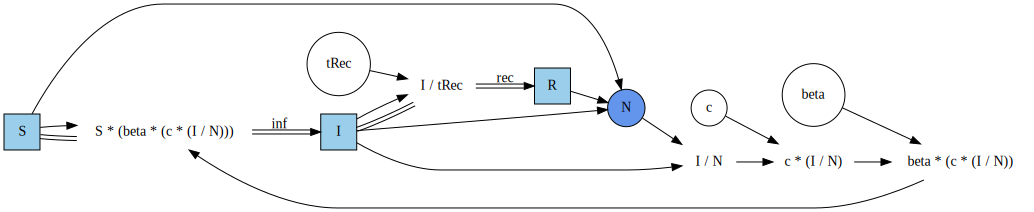

In [3]:
GraphF(SIR)

In [4]:
SVI = @stock_and_flow begin
    :stocks
    S
    V
    I

    :parameters
    vRate
    lambda

    :dynamic_variables
    v_infV = V * lambda

    :flows
    V => infV(v_infV) => I
    S => vac(S * vRate) => V

    :sums
    N = [S, V, I]
    end;

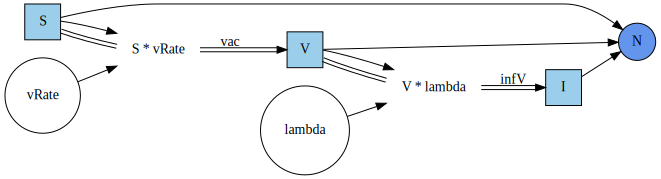

In [5]:
GraphF(SVI)

# Composition
## 1. Compose two diagrams with stocks, sum dynamic variables, and links between them first

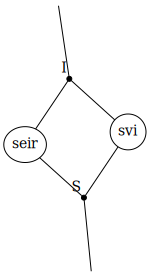

In [6]:
# define the UWD-algebra
sirv_uwd = @relation (S,I) begin
    seir(S,I)
    svi(S,I)
end;
display_uwd(sirv_uwd)

In [7]:
# define a foot of the structured multicospan
footS=foot(:S, :N, :S=>:N)
StockFlow.Graph(footS;schema="C0")

UndefVarError: UndefVarError: `Graph` not defined

In [8]:
# define a foot of the structured multicospan
footI=foot(:I, :N, :I=>:N)
StockFlow.Graph(footI;schema="C0")

UndefVarError: UndefVarError: `Graph` not defined

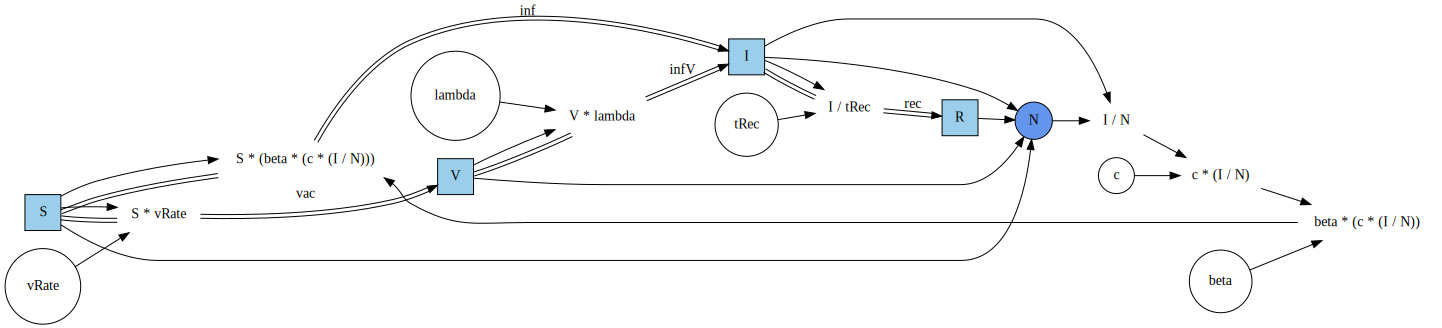

In [9]:
# open sir and svi stock and flow diagram with the feet defined before
open_sir=Open(SIR, footS, footI)
open_svi=Open(SVI, footS, footI)
# Compose those two models according the UWD-algebra
open_sirv = oapply(sirv_uwd, [open_sir, open_svi])
# the composed stock and flow diagram is the apex of the composed open stock and flow diagram
SIRV = apex(open_sirv)
GraphF(SIRV)

## 2. Graph Rewriting

### NOTE: all the parts in the L, I and R (especially the attributes) should be the same as the SIRV diagram, or the natrual transformation will not be natural.

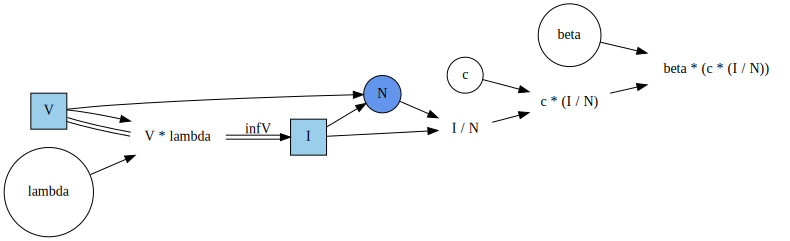

In [10]:
L = StockAndFlowF((:V=>(:F_NONE,:infV,:N), :I=>(:infV,:F_NONE,:N)),# stocks
(:c, :beta, :lambda),# parameters
(:v_prevalence=>((:I,:N)=>:/),:v_meanInfectiousContactsPerS=>((:c,:v_prevalence)=>:*),:v_perSIncidenceRate=>((:beta,:v_meanInfectiousContactsPerS)=>:*),
        :v_infV=>((:V,:lambda)=>:*)),# dynamical variables
(:infV=>:v_infV),# flows
(:N))# sum dynamical variables

GraphF(L)

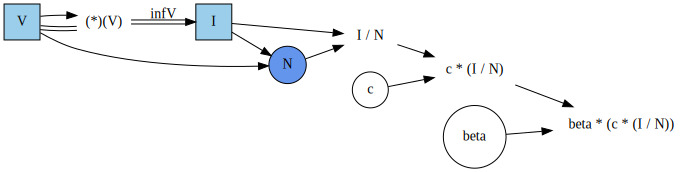

In [11]:
I = StockAndFlowF((:V=>(:F_NONE,:infV,:N), :I=>(:infV,:F_NONE,:N)),# stocks
(:c, :beta),# parameters
(:v_prevalence=>((:I,:N)=>:/),:v_meanInfectiousContactsPerS=>((:c,:v_prevalence)=>:*),:v_perSIncidenceRate=>((:beta,:v_meanInfectiousContactsPerS)=>:*),
        :v_infV=>(:V=>:*)),# dynamical variables
(:infV=>:v_infV),# flows
(:N))# sum dynamical variables
GraphF(I)

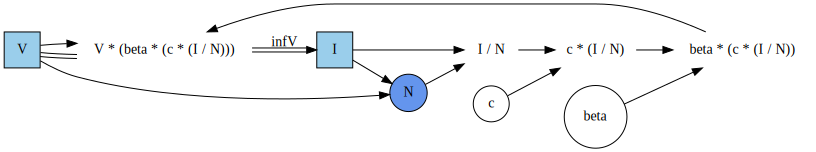

In [12]:
R = StockAndFlowF((:V=>(:F_NONE,:infV,:N), :I=>(:infV,:F_NONE,:N)),# stocks
(:c, :beta),# parameters
(:v_prevalence=>((:I,:N)=>:/),:v_meanInfectiousContactsPerS=>((:c,:v_prevalence)=>:*),:v_perSIncidenceRate=>((:beta,:v_meanInfectiousContactsPerS)=>:*),
        :v_infV=>((:V,:v_perSIncidenceRate)=>:*)),# dynamical variables
(:infV=>:v_infV),# flows
(:N))# sum dynamical variables

GraphF(R)

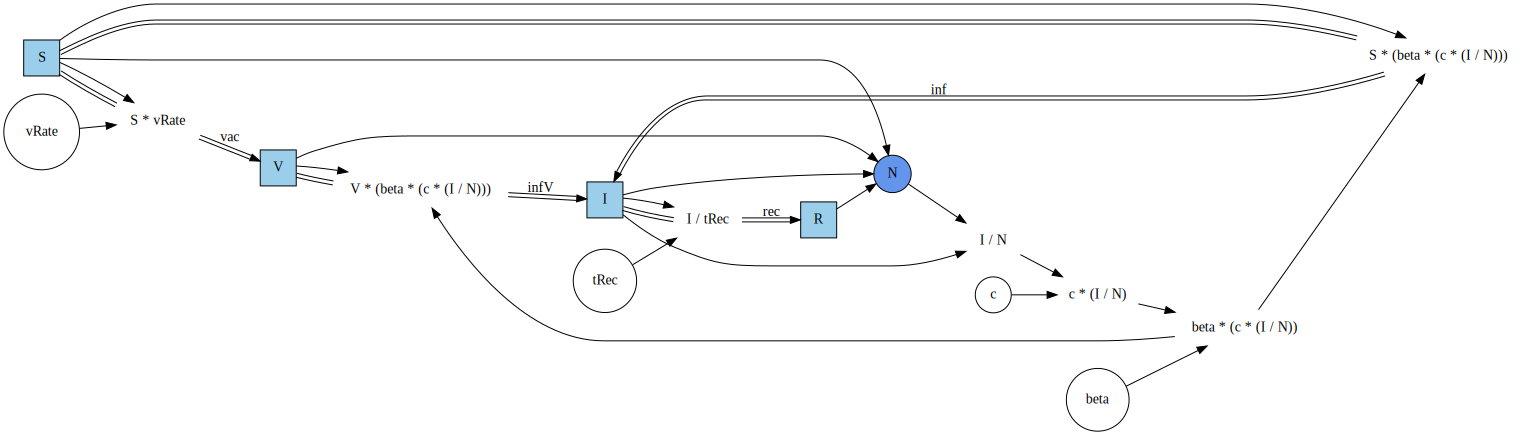

In [13]:
using AlgebraicRewriting
using AlgebraicRewriting: rewrite
const hom = Catlab.CategoricalAlgebra.homomorphism
rule = Rule(hom(I,L), hom(I,R))
SIRV_rewrited = rewrite(rule, SIRV)
GraphF(SIRV_rewrited)

In [14]:
# define values of constant parameters
p_sirv = LVector(
    c=0.5, beta=0.8, tRec=14.0, vRate=0.01
)
# define initial values for stocks
u0_sirv = LVector(
    S=990.0, I=10.0, R=0.0, V=0.0
);

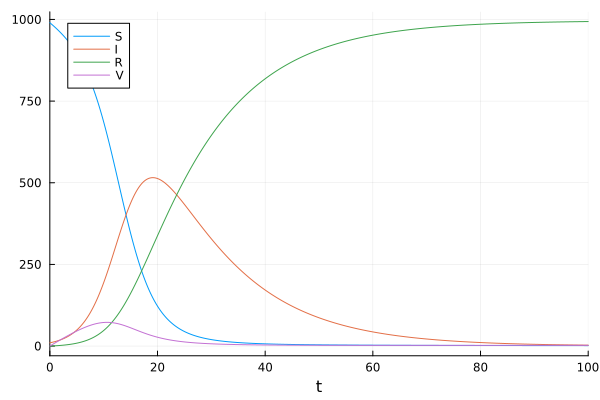

In [15]:
prob_sirv = ODEProblem(vectorfield(SIRV_rewrited),u0_sirv,(0.0,100.0),p_sirv);
sol_sirv = solve(prob_sirv,Tsit5(),abstol=1e-8);
plot(sol_sirv)

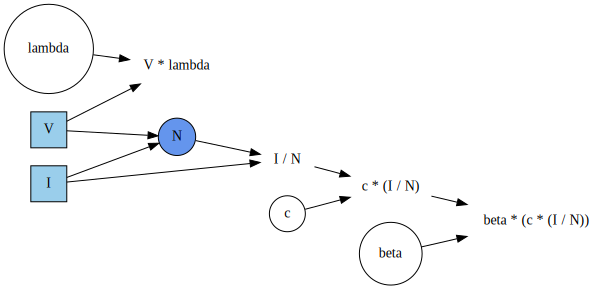

In [16]:
no_flow = StockAndFlowF((:V=>(:F_NONE,:F_NONE,:N), :I=>(:F_NONE,:F_NONE,:N)),# stocks
(:c, :beta, :lambda),# parameters
(:v_prevalence=>((:I,:N)=>:/),:v_meanInfectiousContactsPerS=>((:c,:v_prevalence)=>:*),:v_perSIncidenceRate=>((:beta,:v_meanInfectiousContactsPerS)=>:*),
        :v_infV=>((:V,:lambda)=>:*)),# dynamical variables
(),# flows
(:N))# sum dynamical variables

GraphF(no_flow)

# stratification
## 1. stratify an SIR model (need graph rewriting to redefine the mixing contact part)

In [17]:
using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

In [18]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)

GraphF_typed (generic function with 5 methods)

### 1.1 define the type stock and flow diagram (common part)

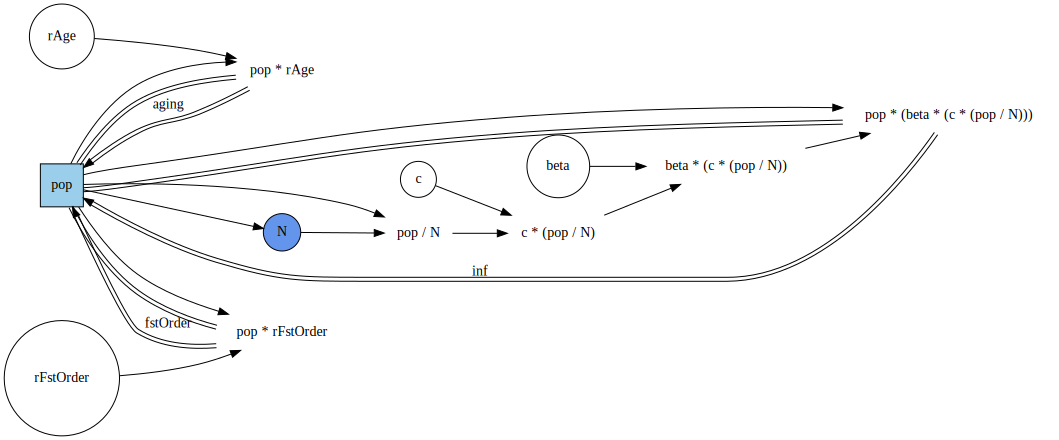

In [19]:
s_type = StockAndFlowF((:pop=>((:aging,:inf,:fstOrder),(:aging,:inf,:fstOrder),:N)),# stocks
(:c, :beta, :rFstOrder, :rAge),# parameters
(:v_prevalence=>((:pop,:N)=>:/),:v_meanInfectiousContactsPerS=>((:c,:v_prevalence)=>:*),:v_perSIncidenceRate=>((:beta,:v_meanInfectiousContactsPerS)=>:*),
        :v_inf=>((:pop,:v_perSIncidenceRate)=>:*),:v_fstOrder=>((:pop,:rFstOrder)=>:*),:v_aging=>((:pop,:rAge)=>:*)),# dynamical variables
(:inf=>:v_inf, :fstOrder=>:v_fstOrder, :aging=>:v_aging),# flows
(:N))# sum dynamical variables

GraphF(s_type)

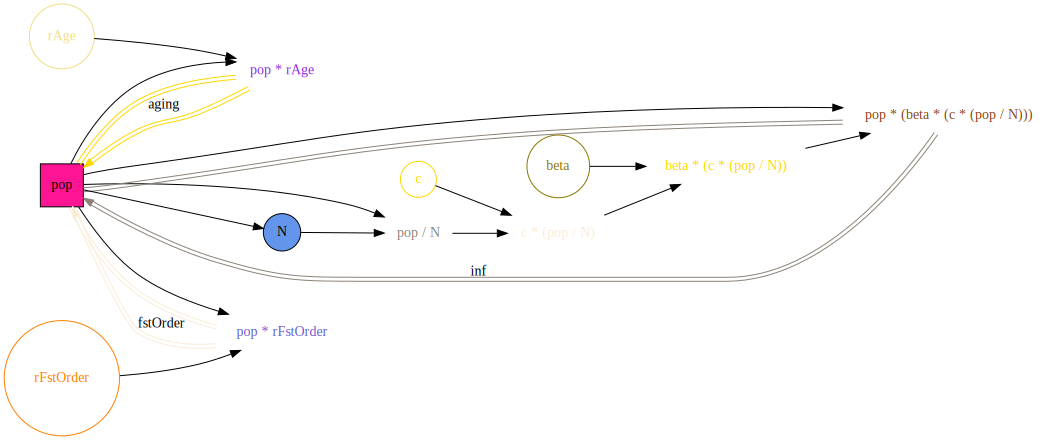

In [20]:
GraphF_typed(id(s_type))

In [21]:
# eliminate the attribute of name to enable pass the natural check
# only eliminate the name, the other two attributes should be okay
s_type = map(s_type, Name=name->nothing, Op=op->nothing, Position=pos->nothing);

#### 1.1.1 Define the index name of each part

In [22]:
s, = parts(s_type, :S)
N, = parts(s_type, :SV)
lsn, = parts(s_type, :LS)
f_inf, f_fstorder, f_aging = parts(s_type, :F)
i_aging, i_inf, i_fstorder = parts(s_type, :I)
o_aging, o_inf, o_fstorder = parts(s_type, :O)
v_IN, v_cIN, v_betacIN, v_inf, v_fstOrder, v_aging = parts(s_type, :V)
lv_IN1, lv_inf1, lv_fstOrder1, lv_aging1 = parts(s_type, :LV)
lsv_IN2, = parts(s_type, :LSV)
p_c, p_beta, p_rfstOrder, p_rAge = parts(s_type, :P)
lvv_cIN2, lvv_betacIN2, lvv_inf2 = parts(s_type, :LVV)
lpv_cIN1, lpv_betacIN1, lpv_fstOrder2, lpv_aging2 = parts(s_type, :LPV)

1:4

## 1.2 define SIR model

In [23]:
sir = StockAndFlowF((:S=>(:id_S,(:inf,:id_S),:N), :I=>((:inf,:id_I),(:rec,:id_I),:N), :R=>((:rec,:id_R),:id_R,:N)),# stocks
(:c, :beta, :rRec, :rAge),# parameters
(:v_prevalence=>((:I,:N)=>:/),:v_meanInfectiousContactsPerS=>((:c,:v_prevalence)=>:*),:v_perSIncidenceRate=>((:beta,:v_meanInfectiousContactsPerS)=>:*),
        :v_newInfetions=>((:S,:v_perSIncidenceRate)=>:*),:v_newRecovery=>((:I,:rRec)=>:*), 
        :v_idS=>((:S,:rAge)=>:*),:v_idI=>((:I,:rAge)=>:*),:v_idR=>((:R,:rAge)=>:*)),# dynamical variables
(:inf=>:v_newInfetions, :rec=>:v_newRecovery, :id_S=>:v_idS, :id_I=>:v_idI, :id_R=>:v_idR),# flows
(:N))# sum dynamical variables


StockAndFlowF {S:3, SV:1, LS:3, F:5, I:5, O:5, V:8, LV:6, LSV:1, P:4, LVV:3, LPV:6, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     S │
│ 2 │     I │
│ 3 │     R │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬───────┐
│ F │ fv │ fname │
├───┼────┼───────┤
│ 1 │  4 │   inf │
│ 2 │  5 │   rec │
│ 3 │  6 │  id_S │
│ 4 │  7 │  id_I │
│ 5 │  8 │  id_R │
└───┴────┴───────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   3 │  1 │
│ 2 │   1 │  2 │
│ 3 │   4 │  2 │
│ 4 │   2 │  3 │
│ 5 │   5 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   3 │  1 │
│ 3 │   2 │  2 │
│ 4 │   4 │  2 │
│ 5 │   5 │  3 │
└───┴─────┴────┘
┌───┬──────────────────────────────┬─────┐
│ V │                        vname │ vop │
├───┼──────────────────────────────┼─────┤
│ 1 │                 v_prevalence │   / │
│ 2 │ v_meanInfectiousContactsPerS │   * │
│ 3 │          v_perSIncidenceRate │   * │
│ 4 │               v_newInfetions │   * │
│ 5 │                v_newRecovery │   * │
│ 6 │                        v_idS │   * │
│ 7 │                        v_idI │   * │
│ 8 │                        v_idR │   * │
└───┴──────────────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   2 │   1 │           1 │
│  2 │   1 │   4 │           1 │
│  3 │   2 │   5 │           1 │
│  4 │   1 │   6 │           1 │
│  5 │   2 │   7 │           1 │
│  6 │   3 │   8 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     c │
│ 2 │  beta │
│ 3 │  rRec │
│ 4 │  rAge │
└───┴───────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             2 │
│   2 │     2 │     3 │             2 │
│   3 │     3 │     4 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    2 │            1 │
│   2 │    2 │    3 │            1 │
│   3 │    3 │    5 │            2 │
│   4 │    4 │    6 │            2 │
│   5 │    4 │    7 │            2 │
│   6 │    4 │    8 │            2 │
└─────┴──────┴──────┴──────────────┘

In [24]:
typed_aggregate_model=ACSetTransformation(sir, s_type,
  S = [s,s,s],
  SV = [N],
  LS = [lsn,lsn,lsn],   
  F = [f_inf, f_fstorder, f_aging, f_aging, f_aging],    
  I = [i_aging, i_inf, i_aging, i_fstorder, i_aging], 
  O = [o_inf, o_aging, o_fstorder, o_aging, o_aging],
  V = [v_IN, v_cIN, v_betacIN, v_inf, v_fstOrder, v_aging, v_aging, v_aging],
  LV = [lv_IN1, lv_inf1, lv_fstOrder1, lv_aging1, lv_aging1, lv_aging1],
  LSV = [lsv_IN2],
  P = [p_c, p_beta, p_rfstOrder, p_rAge],
  LVV = [lvv_cIN2, lvv_betacIN2, lvv_inf2],
  LPV = [lpv_cIN1, lpv_betacIN1, lpv_fstOrder2, lpv_aging2, lpv_aging2, lpv_aging2],
  Name = name -> nothing, Op=op->nothing, Position=pos->nothing
);
@assert is_natural(typed_aggregate_model)

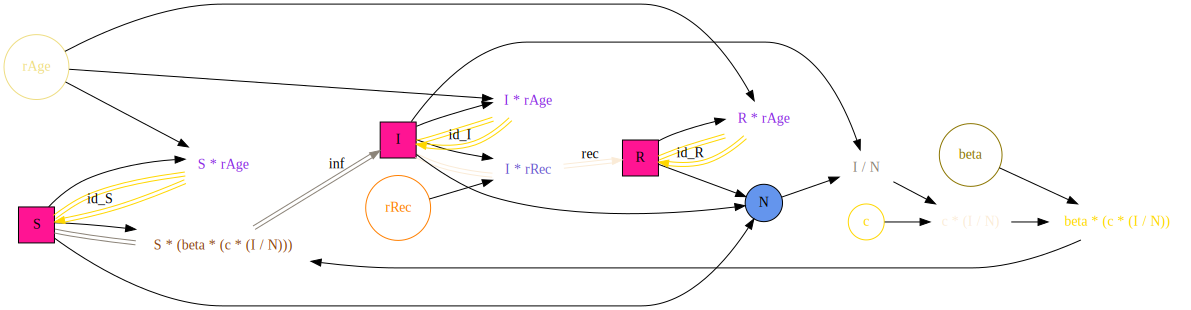

In [25]:
GraphF_typed(typed_aggregate_model)

## 1.3 define the age structure diagram

In [26]:
age2 = StockAndFlowF((:Child=>((:frsC,:infC),(:frsC,:infC,:agingC),:NC), :Adult=>((:frsA,:infA,:agingC),(:frsA,:infA),:NA)),# stocks
(:c_C, :beta, :r, :rAge, :c_A),# parameters
(:v_INC=>((:Child,:NC)=>:/),:v_cINC=>((:c_C,:v_INC)=>:*),:v_cBetaINC=>((:beta,:v_cINC)=>:*),
        :v_infC=>((:Child,:v_cBetaINC)=>:*),:v_fstC=>((:Child,:r)=>:*),:v_agingC=>((:Child,:rAge)=>:*), 
        :v_INA=>((:Adult,:NA)=>:/),:v_cINA=>((:c_A,:v_INA)=>:*),:v_cBetaINA=>((:beta,:v_cINA)=>:*),
        :v_infA=>((:Adult,:v_cBetaINA)=>:*),:v_fstA=>((:Adult,:r)=>:*)),# dynamical variables
(:infC=>:v_infC, :frsC=>:v_fstC, :agingC=>:v_agingC, :infA=>:v_infA, :frsA=>:v_fstA),# flows
(:NC,:NA))# sum dynamical variables

StockAndFlowF {S:2, SV:2, LS:2, F:5, I:5, O:5, V:11, LV:7, LSV:2, P:5, LVV:6, LPV:7, Name:0, Op:0, Position:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │ Child │
│ 2 │ Adult │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │     NC │
│  2 │     NA │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    2 │
└────┴─────┴──────┘
┌───┬────┬────────┐
│ F │ fv │  fname │
├───┼────┼────────┤
│ 1 │  4 │   infC │
│ 2 │  5 │   frsC │
│ 3 │  6 │ agingC │
│ 4 │ 10 │   infA │
│ 5 │ 11 │   frsA │
└───┴────┴────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   1 │  1 │
│ 3 │   5 │  2 │
│ 4 │   4 │  2 │
│ 5 │   3 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   1 │  1 │
│ 3 │   3 │  1 │
│ 4 │   5 │  2 │
│ 5 │   4 │  2 │
└───┴─────┴────┘
┌────┬────────────┬─────┐
│  V │      vname │ vop │
├────┼────────────┼─────┤
│  1 │      v_INC │   / │
│  2 │     v_cINC │   * │
│  3 │ v_cBetaINC │   * │
│  4 │     v_infC │   * │
│  5 │     v_fstC │   * │
│  6 │   v_agingC │   * │
│  7 │      v_INA │   / │
│  8 │     v_cINA │   * │
│  9 │ v_cBetaINA │   * │
│ 10 │     v_infA │   * │
│ 11 │     v_fstA │   * │
└────┴────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   1 │           1 │
│  2 │   1 │   4 │           1 │
│  3 │   1 │   5 │           1 │
│  4 │   1 │   6 │           1 │
│  5 │   2 │   7 │           1 │
│  6 │   2 │  10 │           1 │
│  7 │   2 │  11 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
│   2 │     2 │    7 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │   c_C │
│ 2 │  beta │
│ 3 │     r │
│ 4 │  rAge │
│ 5 │   c_A │
└───┴───────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             2 │
│   2 │     2 │     3 │             2 │
│   3 │     3 │     4 │             2 │
│   4 │     7 │     8 │             2 │
│   5 │     8 │     9 │             2 │
│   6 │     9 │    10 │             2 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    2 │            1 │
│   2 │    2 │    3 │            1 │
│   3 │    3 │    5 │            2 │
│   4 │    4 │    6 │            2 │
│   5 │    5 │    8 │            1 │
│   6 │    2 │    9 │            1 │
│   7 │    3 │   11 │            2 │
└─────┴──────┴──────┴──────────────┘

In [27]:
typed_age_model=ACSetTransformation(age2, s_type,
  S = [s,s],
  SV = [N,N],
  LS = [lsn,lsn],   
  F = [f_inf, f_fstorder, f_aging, f_inf, f_fstorder],    
  I = [i_fstorder, i_inf, i_fstorder, i_inf, i_aging], 
  O = [o_fstorder, o_inf, o_aging, o_fstorder, o_inf],
  V = [v_IN, v_cIN, v_betacIN, v_inf, v_fstOrder, v_aging, v_IN, v_cIN, v_betacIN, v_inf, v_fstOrder],
  LV = [lv_IN1, lv_inf1, lv_fstOrder1, lv_aging1, lv_IN1, lv_inf1, lv_fstOrder1],
  LSV = [lsv_IN2, lsv_IN2],
  P = [p_c, p_beta, p_rfstOrder, p_rAge, p_c],
  LVV = [lvv_cIN2, lvv_betacIN2, lvv_inf2, lvv_cIN2, lvv_betacIN2, lvv_inf2],
  LPV = [lpv_cIN1, lpv_betacIN1, lpv_fstOrder2, lpv_aging2, lpv_cIN1, lpv_betacIN1, lpv_fstOrder2],
  Name = name -> nothing, Op=op->nothing, Position=pos->nothing
);
@assert is_natural(typed_age_model)

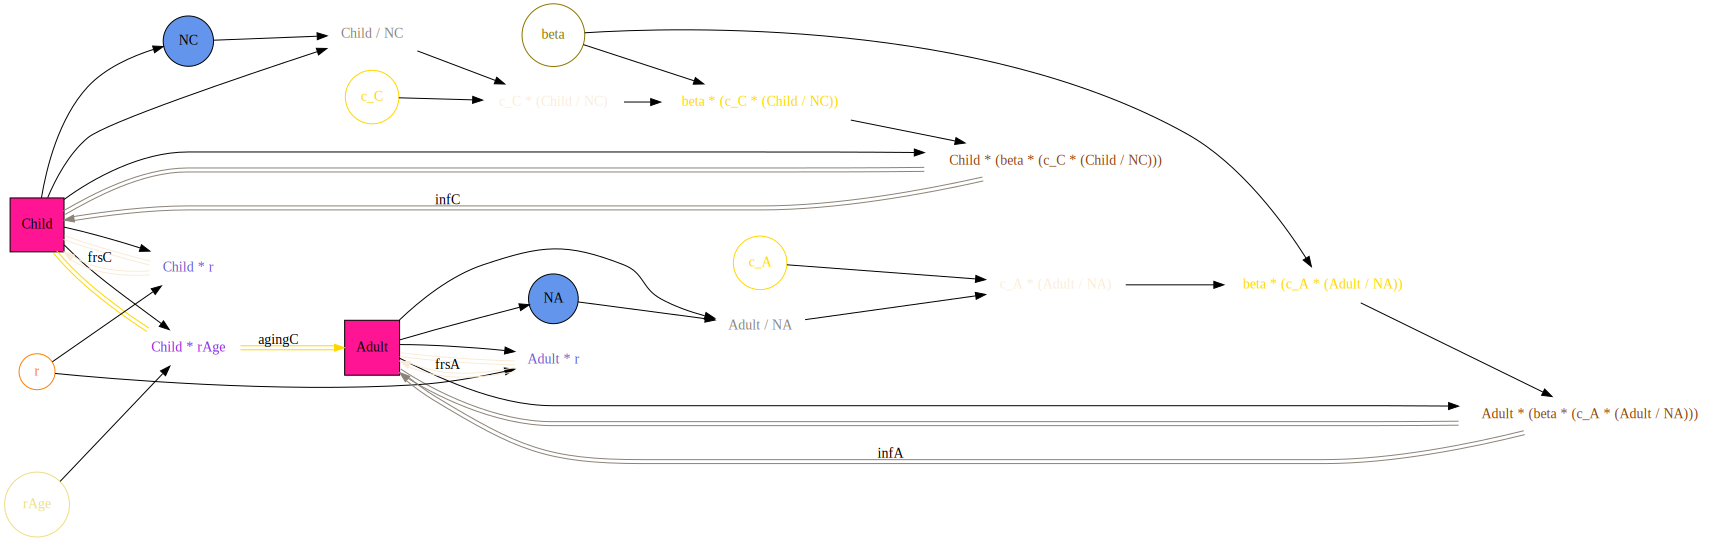

In [28]:
GraphF_typed(typed_age_model)

## 1.4 Calculate pullback and re_create the stratified model

In [29]:
aged_sir = pullback(typed_aggregate_model, typed_age_model) |> apex |> rebuildStratifiedModelByFlattenSymbols;

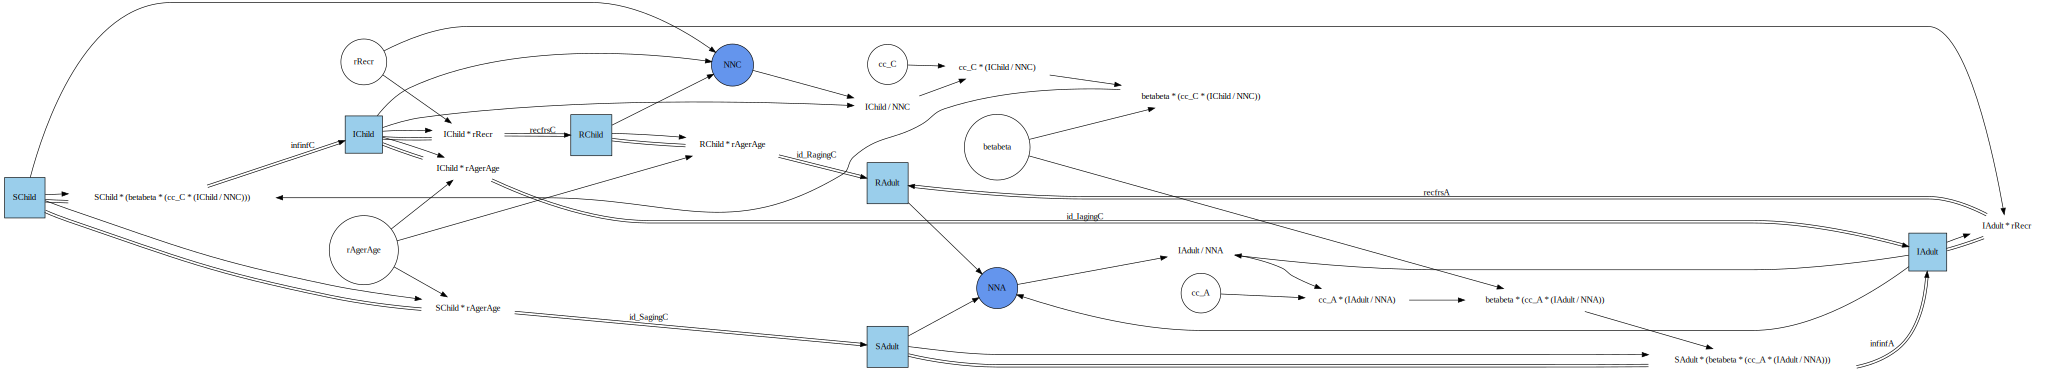

In [30]:
GraphF(aged_sir)

## 1.5 Graph Rewriting to correct the non_linear mixing part

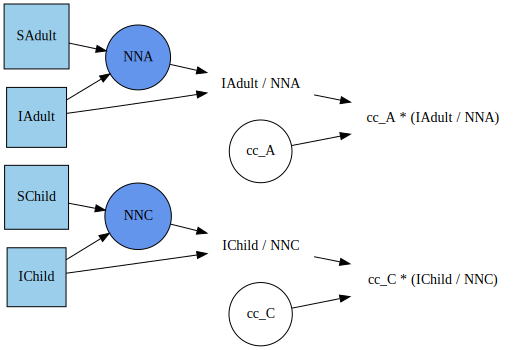

In [31]:
LS = StockAndFlowF((:SChild=>(:F_NONE,:F_NONE,:NNC), :IChild=>(:F_NONE,:F_NONE,:NNC),:SAdult=>(:F_NONE,:F_NONE,:NNA), :IAdult=>(:F_NONE,:F_NONE,:NNA)),# stocks
(:cc_C, :cc_A),# parameters
(:v_prevalencev_INC=>((:IChild,:NNC)=>:/),:v_prevalencev_INA=>((:IAdult,:NNA)=>:/),
        :v_meanInfectiousContactsPerSv_cINC=>((:cc_C,:v_prevalencev_INC)=>:*),:v_meanInfectiousContactsPerSv_cINA=>((:cc_A,:v_prevalencev_INA)=>:*)),# dynamical variables
(),# flows
(:NNC,:NNA))# sum dynamical variables

GraphF(LS)

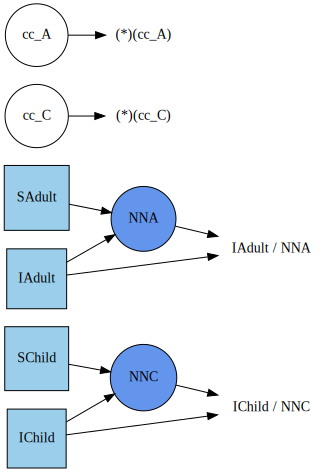

In [32]:
IS = StockAndFlowF((:SChild=>(:F_NONE,:F_NONE,:NNC), :IChild=>(:F_NONE,:F_NONE,:NNC),:SAdult=>(:F_NONE,:F_NONE,:NNA), :IAdult=>(:F_NONE,:F_NONE,:NNA)),# stocks
(:cc_C, :cc_A),# parameters
(:v_prevalencev_INC=>((:IChild,:NNC)=>:/),:v_prevalencev_INA=>((:IAdult,:NNA)=>:/),
        :v_meanInfectiousContactsPerSv_cINC=>((:cc_C)=>:*),:v_meanInfectiousContactsPerSv_cINA=>((:cc_A)=>:*)),# dynamical variables
(),# flows
(:NNC,:NNA))# sum dynamical variables

GraphF(IS)

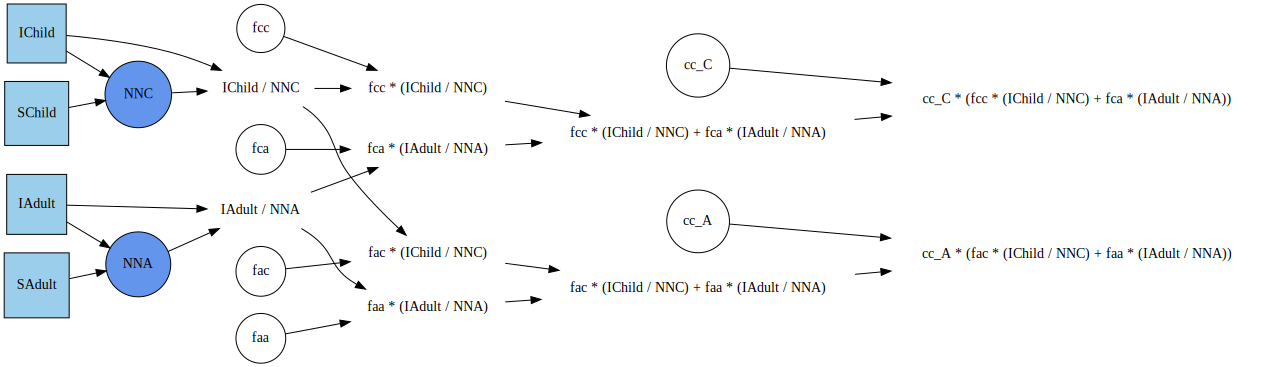

In [33]:
RS = StockAndFlowF((:SChild=>(:F_NONE,:F_NONE,:NNC), :IChild=>(:F_NONE,:F_NONE,:NNC),:SAdult=>(:F_NONE,:F_NONE,:NNA), :IAdult=>(:F_NONE,:F_NONE,:NNA)),# stocks
(:fcc,:fca,:fac,:faa,:cc_C,:cc_A),# parameters
(:v_prevalencev_INC=>((:IChild,:NNC)=>:/),:v_prevalencev_INA=>((:IAdult,:NNA)=>:/),:v_CCContacts=>((:fcc,:v_prevalencev_INC)=>:*),:v_CAContacts=>((:fca,:v_prevalencev_INA)=>:*),
        :v_ACContacts=>((:fac,:v_prevalencev_INC)=>:*),:v_AAContacts=>((:faa,:v_prevalencev_INA)=>:*),
        :v_prevalencev_INC_post=>((:v_CCContacts,:v_CAContacts)=>:+),:v_prevalencev_INA_post=>((:v_ACContacts,:v_AAContacts)=>:+),:v_meanInfectiousContactsPerSv_cINC=>((:cc_C,:v_prevalencev_INC_post)=>:*),:v_meanInfectiousContactsPerSv_cINA=>((:cc_A,:v_prevalencev_INA_post)=>:*)),# dynamical variables
(),# flows
(:NNC,:NNA))# sum dynamical variables

GraphF(RS)

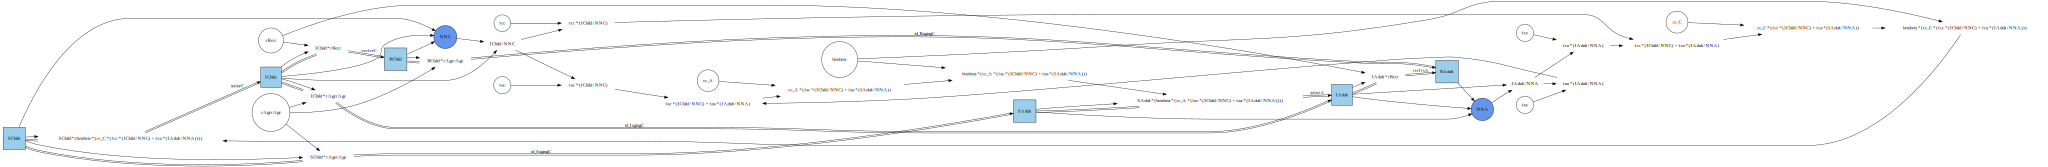

In [34]:
rule_S = Rule(hom(IS,LS), hom(IS,RS))
aged_sir_rewrited = rewrite(rule_S, aged_sir)
GraphF(aged_sir_rewrited)

## 1.6 Generate ODEs and calculate:

In [35]:
# define values of constant parameters
p_stratified_sir = LVector(
    fcc=0.8, fca=0.2, fac=0.2, faa=0.8, cc_C=0.45, cc_A=0.55,
    betabeta=0.8, rRecr=1.0/14.0, rAgerAge=1.0/(15.0*365.0) #which means the child age group is from 0 to 15 years old
)
# define initial values for stocks
u0_stratified_sir = LVector(
    SChild=990.0, IChild=10.0, RChild=0.0,
    SAdult=4900.0, IAdult=10.0, RAdult=0.0
);

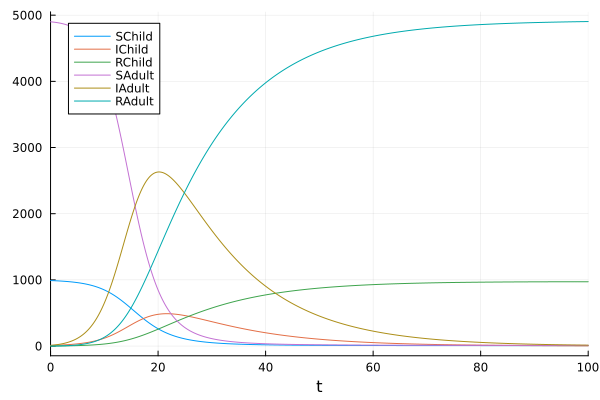

In [36]:
prob_stratified_sir = ODEProblem(vectorfield(aged_sir_rewrited),u0_stratified_sir,(0.0,100.0),p_stratified_sir);
sol_stratified_sir = solve(prob_stratified_sir,Tsit5(),abstol=1e-8);
plot(sol_stratified_sir)

## 2. A stratified model example of a pure linear model

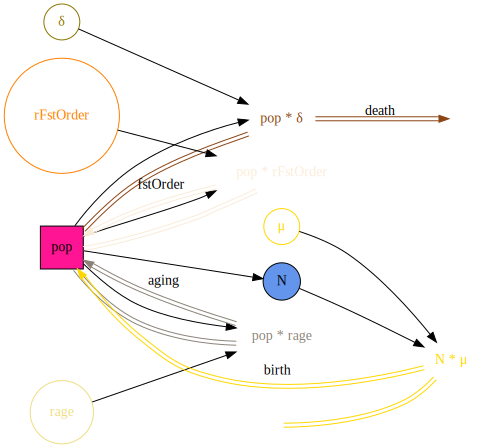

In [37]:
l_type = StockAndFlowF((:pop=>((:aging,:birth,:fstOrder),(:aging,:death,:fstOrder),:N)),# stocks
(:μ, :δ, :rFstOrder, :rage),# parameters
(:v_aging=>((:pop,:rage)=>:*),:v_fstOrder=>((:pop,:rFstOrder)=>:*),:v_birth=>((:N,:μ)=>:*),:v_death=>((:pop,:δ)=>:*)),# dynamical variables
(:aging=>:v_aging, :fstOrder=>:v_fstOrder, :birth=>:v_birth, :death=>:v_death),# flows
(:N))# sum dynamical variables

GraphF_typed(id(l_type))

In [38]:
# eliminate the attribute of name to enable pass the natural check
# only eliminate the name, the other two attributes should be okay
l_type = map(l_type, Name=name->nothing, Op=op->nothing, Position=pos->nothing);

In [39]:
s, = parts(l_type, :S)
N, = parts(l_type, :SV)
lsn, = parts(l_type, :LS)
f_aging, f_fstorder, f_birth, f_death = parts(l_type, :F)
i_aging, i_birth, i_fstorder = parts(l_type, :I)
o_aging, o_death, o_fstorder = parts(l_type, :O)
v_aging, v_fstorder, v_birth, v_death = parts(l_type, :V)
lv_aging1, lv_fstorder1, lv_death1 = parts(l_type, :LV)
lsv_birth1, = parts(l_type, :LSV)
p_μ, p_δ, p_rfstOrder, p_rage = parts(l_type, :P)
lpv_aging2, lpv_fstorder2, lpv_birth2, lpv_death2 = parts(l_type, :LPV)

1:4

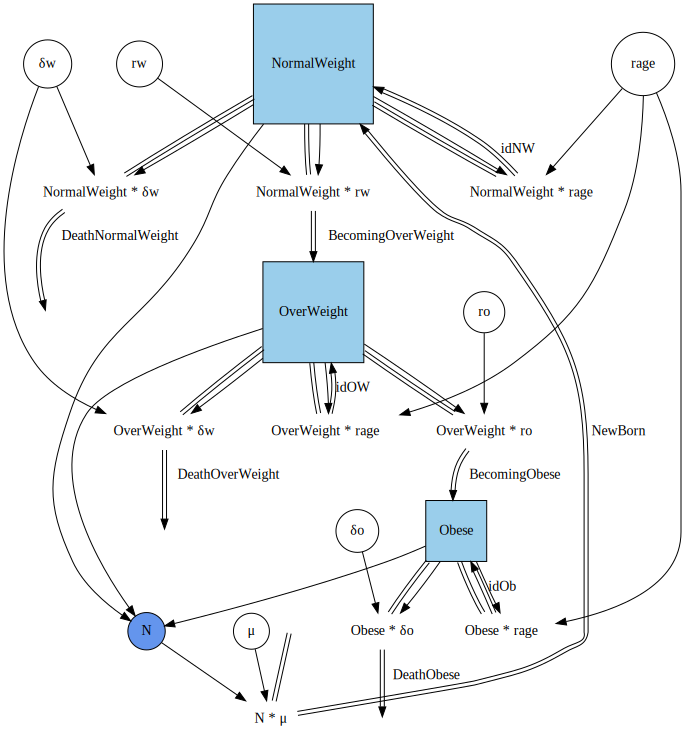

In [40]:
WeightModel = StockAndFlowF(
    #stocks
    (:NormalWeight=>((:NewBorn,:idNW),(:DeathNormalWeight,:BecomingOverWeight,:idNW),:N),
        :OverWeight=>((:BecomingOverWeight,:idOW),(:DeathOverWeight,:BecomingObese,:idOW),:N),
        :Obese=>((:BecomingObese,:idOb),(:DeathObese,:idOb),:N)),
    
    # parameters
    (:μ, :δw, :rw, :ro, :δo, :rage),
    
    #dynamical variables
    (:v_NewBorn=>((:N,:μ)=>:*), :v_DeathNormalWeight=>((:NormalWeight,:δw)=>:*), :v_BecomingOverWeight=>((:NormalWeight,:rw)=>:*),
        :v_DeathOverWeight=>((:OverWeight,:δw)=>:*),:v_BecomingObese=>((:OverWeight,:ro)=>:*),:v_DeathObese=>((:Obese,:δo)=>:*),
        :v_idNW=>((:NormalWeight,:rage)=>:*),:v_idOW=>((:OverWeight,:rage)=>:*),:v_idOb=>((:Obese,:rage)=>:*)),
   
    #flows
    (:NewBorn=>:v_NewBorn, :DeathNormalWeight=>:v_DeathNormalWeight,:BecomingOverWeight=>:v_BecomingOverWeight,:DeathOverWeight=>:v_DeathOverWeight,
        :BecomingObese=>:v_BecomingObese, :DeathObese=>:v_DeathObese, :idNW=>:v_idNW, :idOW=>:v_idOW, :idOb=>:v_idOb),
    
    #sum dynamical variables
    (:N)
)

GraphF(WeightModel, rd="TB")

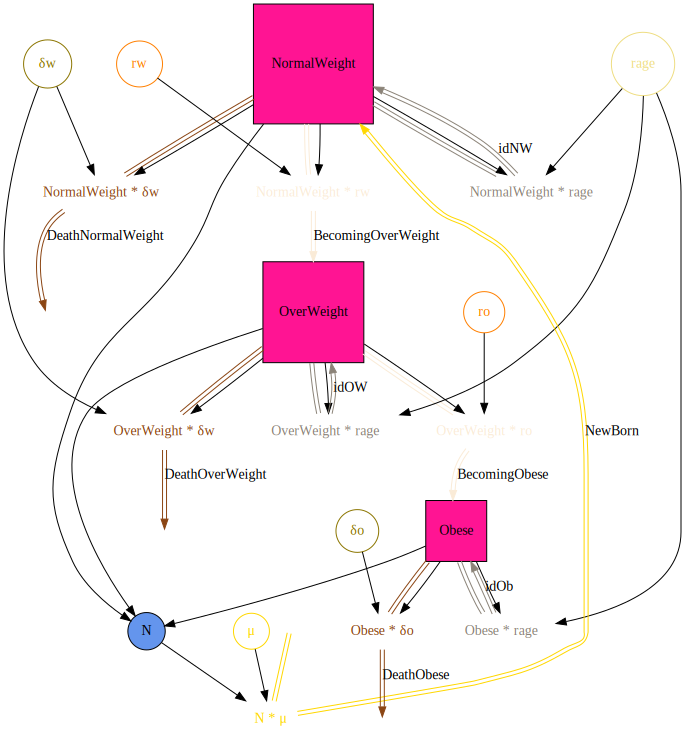

In [41]:
typed_WeightModel=ACSetTransformation(WeightModel, l_type,
  S = [s,s,s],
  SV = [N],
  LS = [lsn,lsn,lsn],   
  F = [f_birth, f_death, f_fstorder, f_death, f_fstorder, f_death, f_aging, f_aging, f_aging],    
  I = [i_birth, i_aging, i_fstorder, i_aging, i_fstorder, i_aging], 
  O = [o_death, o_fstorder, o_aging, o_death, o_fstorder, o_aging, o_death, o_aging],
  V = [v_birth, v_death, v_fstorder, v_death, v_fstorder, v_death, v_aging, v_aging, v_aging],
  LV = [lv_death1, lv_fstorder1, lv_death1, lv_fstorder1, lv_death1, lv_aging1, lv_aging1, lv_aging1],
  LSV = [lsv_birth1],
  P = [p_μ, p_δ, p_rfstOrder, p_rfstOrder, p_δ, p_rage],
  LPV = [lpv_birth2, lpv_death2, lpv_fstorder2, lpv_death2, lpv_fstorder2, lpv_death2, lpv_aging2, lpv_aging2, lpv_aging2],
  Name = name -> nothing, Op=op->nothing, Position=pos->nothing
);
@assert is_natural(typed_WeightModel)
GraphF_typed(typed_WeightModel, rd="TB")

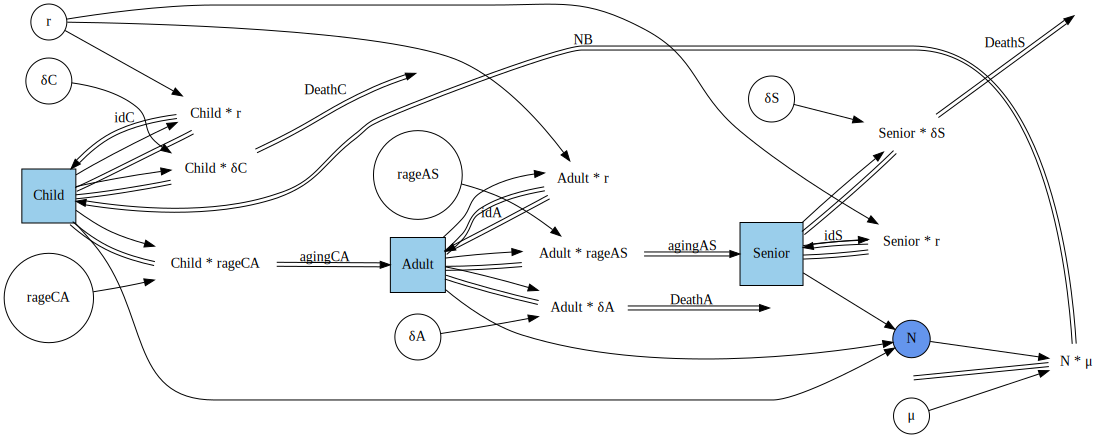

In [42]:
ageWeightModel = StockAndFlowF(
    #stocks
    (:Child=>((:NB,:idC),(:DeathC,:idC,:agingCA),:N),
        :Adult=>((:agingCA,:idA),(:DeathA,:agingAS,:idA),:N),
        :Senior=>((:agingAS,:idS),(:DeathS,:idS),:N)),
    
    # parameters
    (:μ, :δC, :δA, :δS, :rageCA, :rageAS, :r),
    
    #dynamical variables
    (:v_NB=>((:N,:μ)=>:*), :v_DeathC=>((:Child,:δC)=>:*), :v_idC=>((:Child,:r)=>:*), :v_agingCA=>((:Child,:rageCA)=>:*),
        :v_DeathA=>((:Adult,:δA)=>:*), :v_idA=>((:Adult,:r)=>:*), :v_agingAS=>((:Adult,:rageAS)=>:*),
        :v_DeathS=>((:Senior,:δS)=>:*), :v_idS=>((:Senior,:r)=>:*)),
   
    #flows
    (:NB=>:v_NB, :idC=>:v_idC, :DeathC=>:v_DeathC, :agingCA=>:v_agingCA,
        :idA=>:v_idA, :DeathA=>:v_DeathA, :agingAS=>:v_agingAS,
        :idS=>:v_idS, :DeathS=>:v_DeathS),
    
    #sum dynamical variables
    (:N)
)

GraphF(ageWeightModel)

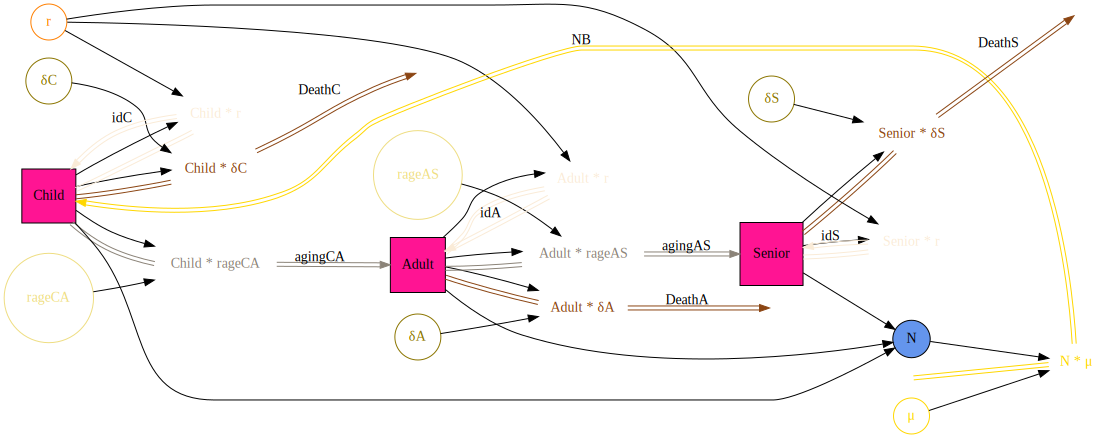

In [43]:
typed_ageWeightModel=ACSetTransformation(ageWeightModel, l_type,
  S = [s,s,s],
  SV = [N],
  LS = [lsn,lsn,lsn],   
  F = [f_birth, f_fstorder, f_death, f_aging, f_fstorder, f_death, f_aging, f_fstorder, f_death],    
  I = [i_birth, i_fstorder, i_aging, i_fstorder, i_aging, i_fstorder], 
  O = [o_death, o_fstorder, o_aging, o_death, o_aging, o_fstorder, o_death, o_fstorder],
  V = [v_birth, v_death, v_fstorder, v_aging, v_death, v_fstorder, v_aging, v_death, v_fstorder],
  LV = [lv_death1, lv_fstorder1, lv_aging1, lv_death1, lv_fstorder1, lv_aging1, lv_death1, lv_fstorder1],
  LSV = [lsv_birth1],
  P = [p_μ, p_δ, p_δ, p_δ, p_rage, p_rage, p_rfstOrder],
  LPV = [lpv_birth2, lpv_death2, lpv_fstorder2, lpv_aging2, lpv_death2, lpv_fstorder2, lpv_aging2, lpv_death2, lpv_fstorder2],
  Name = name -> nothing, Op=op->nothing, Position=pos->nothing
);
@assert is_natural(typed_ageWeightModel)
GraphF_typed(typed_ageWeightModel)

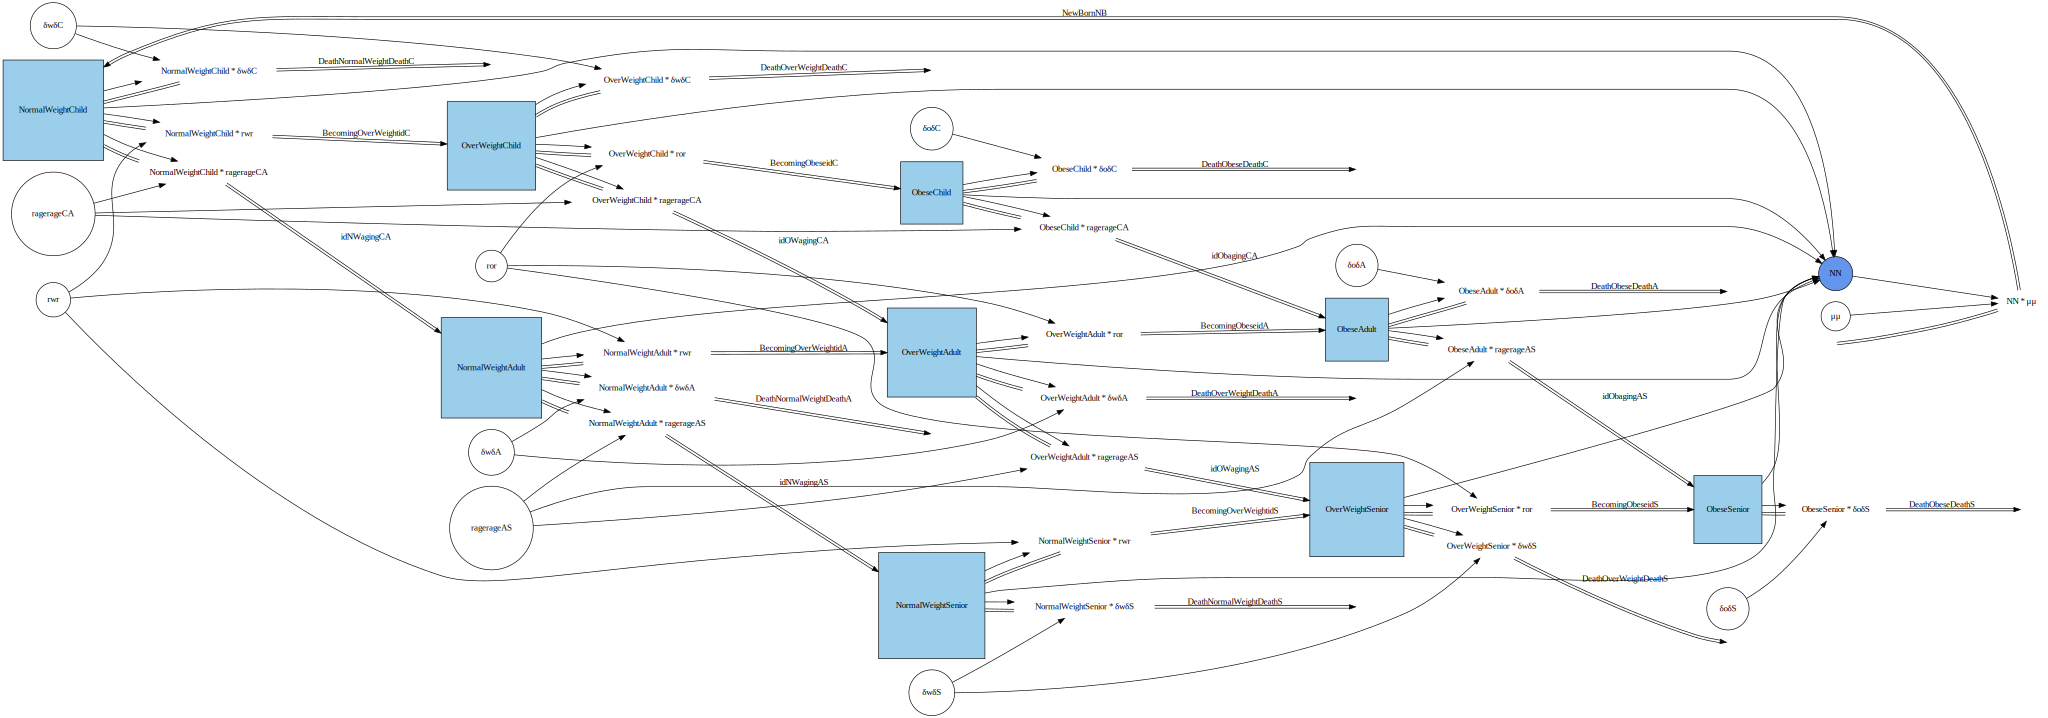

In [44]:
aged_weight = pullback(typed_WeightModel, typed_ageWeightModel) |> apex |> rebuildStratifiedModelByFlattenSymbols;
GraphF(aged_weight)

In [45]:
p_weight = LVector(
    μμ=12.5/1000,δwδC=2.0/1000,δoδC=8.0/1000,δwδA=4.0/1000,δoδA=13.0/1000,δwδS=8.0/1000,δoδS=30.0/1000,
    ragerageCA=1.0/(12.0*365.0),ragerageAS=1.0/(50.0*365.0),rwr=0.03,ror=0.06
)

u0_weight = LVector(
    NormalWeightChild=95811.0*12.0/82.0, OverWeightChild=27709.0*12.0/82.0, ObeseChild=30770.0*12.0/82.0,
    NormalWeightAdult=95811.0*50.0/82.0, OverWeightAdult=27709.0*50.0/82.0, ObeseAdult=30770.0*50.0/82.0,
    NormalWeightSenior=95811.0*20.0/82.0, OverWeightSenior=27709.0*20.0/82.0, ObeseSenior=30770.0*20.0/82.0
);

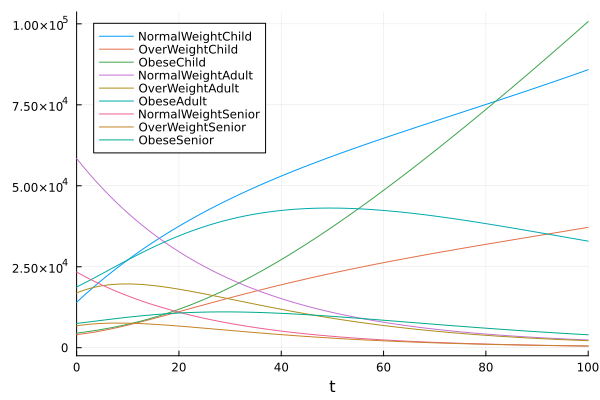

In [46]:
prob_stratified_weight = ODEProblem(vectorfield(aged_weight),u0_weight,(0.0,100.0),p_weight);
sol_stratified_weight = solve(prob_stratified_weight,Tsit5(),abstol=1e-8);
plot(sol_stratified_weight)

# 3. System structure diagram and functors from/to stock and flow diagram

In [47]:
SIRstructure = StockAndFlowStructureF((:S=>(:F_NONE,:inf,:N), :I=>(:inf,:rec,:N), :R=>(:rec,:F_NONE,:N)),# stocks
(:c, :beta, :tRec),# parameters
(:v_prevalence=>(:I,:N),:v_meanInfectiousContactsPerS=>(:c,:v_prevalence),:v_perSIncidenceRate=>(:beta,:v_meanInfectiousContactsPerS),
        :v_newInfetions=>(:S,:v_perSIncidenceRate),:v_newRecovery=>(:I,:tRec)),# dynamical variables
(:inf=>:v_newInfetions, :rec=>:v_newRecovery),# flows
(:N));# sum dynamical variables

In [48]:
v=(:v_prevalence=>((:I,:N)=>:/),:v_meanInfectiousContactsPerS=>((:c,:v_prevalence)=>:*),:v_perSIncidenceRate=>((:beta,:v_meanInfectiousContactsPerS)=>:*),
        :v_newInfetions=>((:S,:v_perSIncidenceRate)=>:*),:v_newRecovery=>((:I,:tRec)=>:/))# dynamical variables


(:v_prevalence => ((:I, :N) => :/), :v_meanInfectiousContactsPerS => ((:c, :v_prevalence) => :*), :v_perSIncidenceRate => ((:beta, :v_meanInfectiousContactsPerS) => :*), :v_newInfetions => ((:S, :v_perSIncidenceRate) => :*), :v_newRecovery => ((:I, :tRec) => :/))

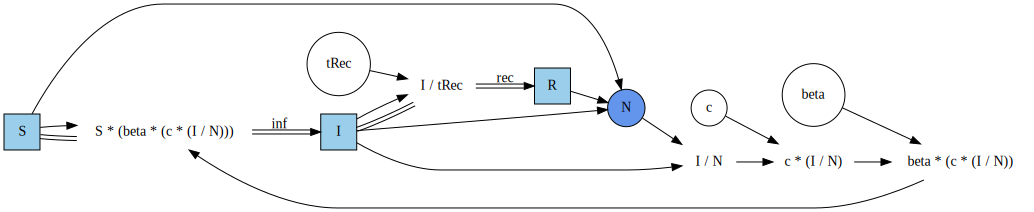

In [49]:
sir_converted=convertSystemStructureToStockFlow(SIRstructure,v)
GraphF(sir_converted)

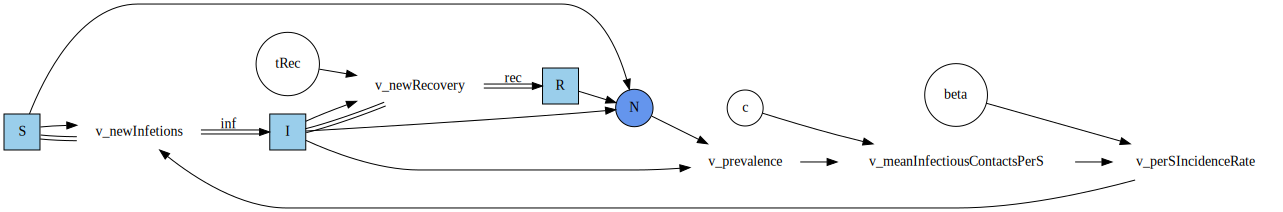

In [50]:
sirstructure_converted=convertStockFlowToSystemStructure(sir_converted);
GraphF(sirstructure_converted)

# 4. Causal loop diagram and functors from stock and flow diagram to it

In [51]:
Graph = StockFlow.Graph

Catlab.Graphics.Graphviz.Graph

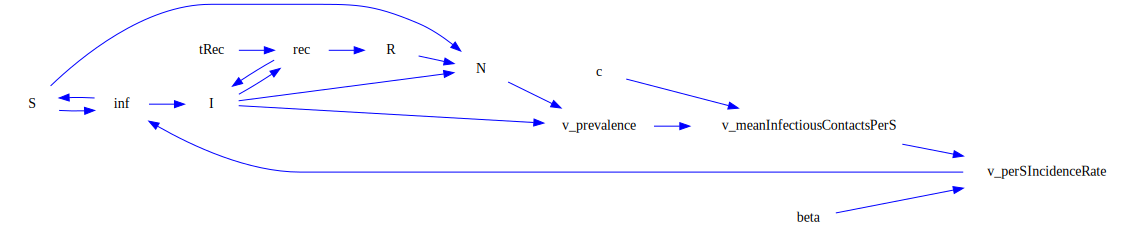

In [52]:
causalloop=convertToCausalLoop(SIRstructure)
GraphCL(causalloop)